In [1]:
import pandas as pd
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False
from google.colab import drive
drive.mount('/content/gdrive')


NanumBarunGothic
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


* 제조업 업황 전망 지수
* 종합주가지수
* 제조업 재고 물량지수
* 제조업 재고순환지표
* 장단기금리차
* 순교역조건

In [2]:
# 이 코드는 한국은행 경제통계시스템 (ECOS)의 자료를 다운 받습니다.

import datetime                     
import requests
import pandas as pd
from bs4 import BeautifulSoup


# ECOS 에서 데이터를 호출하는 함수를 만듭니다.

def EcosDownload(Statcode, Freq, Begdate, Enddate, Subcode1, Subcode2, Subcode3):
    
    url = 'http://ecos.bok.or.kr/api/StatisticSearch/HA5OFFNUUGG4TD13CMHV/xml/kr/1/100000/%s/%s/%s/%s/%s/%s/%s/'%(Statcode, Freq, Begdate, Enddate, Subcode1, Subcode2, Subcode3)

    raw = requests.get(url)
    xml = BeautifulSoup(raw.text,'xml')


    # Pandas 데이터프레임으로 전환합니다.

    raw_data = xml.find_all("row")

    date_list = []
    value_list = []

    for item in raw_data:
         
            value = item.find('DATA_VALUE').text.encode('utf-8')
            date_str = item.find('TIME').text
            
            value = float(value)
                
            date_list.append(datetime.datetime.strptime(date_str,'%Y%m'))
            value_list.append(value)
            
    df = pd.DataFrame(index = date_list)
    
    df['value'] = value_list
      
    return df


In [3]:
room=EcosDownload('028Y001', 'MM', '199401', '202203', 'BEEA14', '', '')
room.columns=['기준금리']
room=room.reset_index()
room=room.drop('기준금리',axis=1)
room

,index
0,1994-01-01
1,1994-02-01
2,1994-03-01
3,1994-04-01
4,1994-05-01
...,...
334,2021-11-01
335,2021-12-01
336,2022-01-01
337,2022-02-01


In [4]:
df=room.copy()
for code in [['099Y005','A','교역조건지수'],['I10Y002','3010101','주가지수'],
             ['028Y001','BEEA42','국채3'],
             ['028Y001','BEEA422','국채10']]:
    df2=EcosDownload(code[0], 'MM', '199401', '202205', code[1], '', '')
    df2.columns=[code[2]]
    df2=df2.reset_index()
    df=pd.merge(df, df2 , on="index", how="outer") 


In [5]:
d1=EcosDownload('080Y110', 'MM', '199401', '202205', 'I31ABA', 'I10F', '').reset_index() #재고
d2=EcosDownload('080Y110', 'MM', '199401', '202205', 'I31ABA', 'I10D', '').reset_index() #출하
d3=EcosDownload('080Y110', 'MM', '199401', '202205', 'I31ABA', 'I10B', '').reset_index() #생산
d4=EcosDownload('041Y014', 'MM', '199401', '202205', 'C0000', '', 'BA').reset_index() #업황전망
d5=EcosDownload('085Y026', 'MM', '199401', '202205', 'I16D', '', '').reset_index() #동행지수

d1.columns=['index','제조업 재고지수']
d2.columns=['index','제조업 출하지수']
d3.columns=['index','제조업 생산지수']
d4.columns=['index','제조업 업황전망']
d5.columns=['index','경기동행지수']
rr=pd.merge(d1, d2 , on="index", how="outer")
rr=pd.merge(rr, d3 , on="index", how="outer")
rr=pd.merge(rr, d4 , on="index", how="outer")
rr=pd.merge(rr, d5 , on="index", how="outer")

In [6]:
df=pd.merge(df, rr , on="index", how="outer")

In [7]:
df.dropna()

,index,교역조건지수,주가지수,국채3,국채10,제조업 재고지수,제조업 출하지수,제조업 생산지수,제조업 업황전망,경기동행지수
109,2003-02-01,152.12,575.43,4.730,5.150,36.2,42.0,37.7,87.0,100.7
110,2003-03-01,150.15,535.70,4.780,5.200,37.0,42.5,38.5,91.0,100.4
111,2003-04-01,150.53,599.35,4.600,5.030,37.6,42.7,38.0,79.0,99.8
112,2003-05-01,152.62,633.42,4.270,4.680,37.3,42.8,37.7,87.0,99.7
113,2003-06-01,152.93,669.93,4.070,4.460,37.6,43.6,39.0,81.0,99.7
...,...,...,...,...,...,...,...,...,...,...
334,2021-11-01,88.37,2839.01,1.953,2.355,125.4,121.3,133.7,88.0,101.1
335,2021-12-01,87.70,2977.65,1.800,2.187,125.9,122.8,137.6,88.0,101.8
336,2022-01-01,89.27,2663.34,2.060,2.492,127.6,124.8,139.5,92.0,102.4
337,2022-02-01,87.63,2699.18,2.285,2.690,131.3,123.5,141.9,90.0,102.6


In [8]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime



plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'

In [9]:
# Composite Leading Indicator

# https://data.oecd.org/leadind/composite-leading-indicator-cli.htm

def getCLI(country):
    uri = 'https://stats.oecd.org/sdmx-json/data/DP_LIVE/' + country + '.CLI.AMPLITUD.LTRENDIDX.M/OECD?json-lang=en&dimensionAtObservation=allDimensions&startPeriod=2000-01&endPeriod=2022-10'
    resp = requests.get(uri)
    result = json.loads(resp.text)
    dates = []
    cli = []
    cli_code = 'CLI.' + country
    observations = result['dataSets'][0]['observations']
    for key in observations:
        obs = observations[key][0]
        cli.append(obs)
    time_period = result['structure']['dimensions']['observation'][5]['values']

    for date in time_period:
        date = date['id']
        year = int(date[:4])
        month = int(date[5:7])
        dates.append(datetime(year=year, month=month, day=1))
    df = pd.DataFrame(data=cli, index=dates, columns=[cli_code])

    return df

In [10]:
clikor = getCLI('KOR')

In [11]:
df=df.set_index('index')

In [12]:
df2=df.shift(1).dropna()

In [13]:
df2=df2.reset_index()

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     230 non-null    datetime64[ns]
 1   교역조건지수    230 non-null    float64       
 2   주가지수      230 non-null    float64       
 3   국채3       230 non-null    float64       
 4   국채10      230 non-null    float64       
 5   제조업 재고지수  230 non-null    float64       
 6   제조업 출하지수  230 non-null    float64       
 7   제조업 생산지수  230 non-null    float64       
 8   제조업 업황전망  230 non-null    float64       
 9   경기동행지수    230 non-null    float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 18.1 KB


In [15]:
clikor=clikor.reset_index()

In [16]:
df2=pd.merge(df2, clikor , on="index", how="outer")

In [17]:
df2=df2.dropna()

In [18]:
df2['장단기 금리차']=df2['국채10']-df2['국채3']
df2

,index,교역조건지수,주가지수,국채3,국채10,제조업 재고지수,제조업 출하지수,제조업 생산지수,제조업 업황전망,경기동행지수,CLI.KOR,장단기 금리차
0,2003-03-01,152.12,575.43,4.730,5.150,36.2,42.0,37.7,87.0,100.7,98.54265,0.420
1,2003-04-01,150.15,535.70,4.780,5.200,37.0,42.5,38.5,91.0,100.4,98.30023,0.420
2,2003-05-01,150.53,599.35,4.600,5.030,37.6,42.7,38.0,79.0,99.8,98.23922,0.430
3,2003-06-01,152.62,633.42,4.270,4.680,37.3,42.8,37.7,87.0,99.7,98.35496,0.410
4,2003-07-01,152.93,669.93,4.070,4.460,37.6,43.6,39.0,81.0,99.7,98.60952,0.390
...,...,...,...,...,...,...,...,...,...,...,...,...
225,2021-12-01,88.37,2839.01,1.953,2.355,125.4,121.3,133.7,88.0,101.1,99.99874,0.402
226,2022-01-01,87.70,2977.65,1.800,2.187,125.9,122.8,137.6,88.0,101.8,99.75789,0.387
227,2022-02-01,89.27,2663.34,2.060,2.492,127.6,124.8,139.5,92.0,102.4,99.54153,0.432
228,2022-03-01,87.63,2699.18,2.285,2.690,131.3,123.5,141.9,90.0,102.6,99.34025,0.405


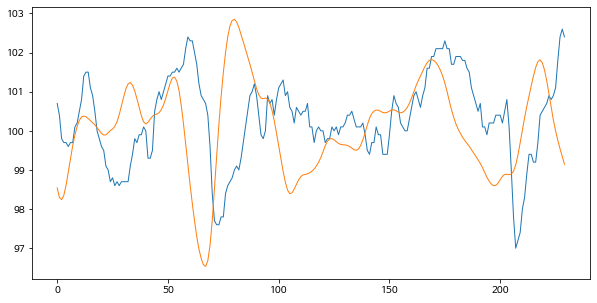

In [21]:
df2.경기동행지수.plot()
df2['CLI.KOR'].plot()

In [23]:
df2=df2.set_index('index')

In [24]:
a_df=df2[['교역조건지수', '주가지수', '제조업 재고지수', '제조업 출하지수', '제조업 생산지수',
       '제조업 업황전망','장단기 금리차','경기동행지수','CLI.KOR']]
a_df

,교역조건지수,주가지수,제조업 재고지수,제조업 출하지수,제조업 생산지수,제조업 업황전망,장단기 금리차,경기동행지수,CLI.KOR
index,,,,,,,,,
2003-03-01,152.12,575.43,36.2,42.0,37.7,87.0,0.420,100.7,98.54265
2003-04-01,150.15,535.70,37.0,42.5,38.5,91.0,0.420,100.4,98.30023
2003-05-01,150.53,599.35,37.6,42.7,38.0,79.0,0.430,99.8,98.23922
2003-06-01,152.62,633.42,37.3,42.8,37.7,87.0,0.410,99.7,98.35496
2003-07-01,152.93,669.93,37.6,43.6,39.0,81.0,0.390,99.7,98.60952
...,...,...,...,...,...,...,...,...,...
2021-12-01,88.37,2839.01,125.4,121.3,133.7,88.0,0.402,101.1,99.99874
2022-01-01,87.70,2977.65,125.9,122.8,137.6,88.0,0.387,101.8,99.75789
2022-02-01,89.27,2663.34,127.6,124.8,139.5,92.0,0.432,102.4,99.54153


In [26]:
two_df=a_df.copy()

In [27]:
two_df.경기동행지수=two_df.경기동행지수.shift(-3)
two_df

,교역조건지수,주가지수,제조업 재고지수,제조업 출하지수,제조업 생산지수,제조업 업황전망,장단기 금리차,경기동행지수,CLI.KOR
index,,,,,,,,,
2003-03-01,152.12,575.43,36.2,42.0,37.7,87.0,0.420,99.7,98.54265
2003-04-01,150.15,535.70,37.0,42.5,38.5,91.0,0.420,99.7,98.30023
2003-05-01,150.53,599.35,37.6,42.7,38.0,79.0,0.430,99.6,98.23922
2003-06-01,152.62,633.42,37.3,42.8,37.7,87.0,0.410,99.7,98.35496
2003-07-01,152.93,669.93,37.6,43.6,39.0,81.0,0.390,99.7,98.60952
...,...,...,...,...,...,...,...,...,...
2021-12-01,88.37,2839.01,125.4,121.3,133.7,88.0,0.402,102.6,99.99874
2022-01-01,87.70,2977.65,125.9,122.8,137.6,88.0,0.387,102.4,99.75789
2022-02-01,89.27,2663.34,127.6,124.8,139.5,92.0,0.432,NaN,99.54153


In [28]:
two_df=two_df.dropna()

In [29]:
two_df

,교역조건지수,주가지수,제조업 재고지수,제조업 출하지수,제조업 생산지수,제조업 업황전망,장단기 금리차,경기동행지수,CLI.KOR
index,,,,,,,,,
2003-03-01,152.12,575.43,36.2,42.0,37.7,87.0,0.420,99.7,98.54265
2003-04-01,150.15,535.70,37.0,42.5,38.5,91.0,0.420,99.7,98.30023
2003-05-01,150.53,599.35,37.6,42.7,38.0,79.0,0.430,99.6,98.23922
2003-06-01,152.62,633.42,37.3,42.8,37.7,87.0,0.410,99.7,98.35496
2003-07-01,152.93,669.93,37.6,43.6,39.0,81.0,0.390,99.7,98.60952
...,...,...,...,...,...,...,...,...,...
2021-09-01,91.94,3199.27,116.1,119.5,134.8,92.0,0.494,101.1,100.94250
2021-10-01,92.65,3068.82,121.2,118.5,132.6,96.0,0.546,101.8,100.59340
2021-11-01,91.56,2970.68,124.6,117.7,131.5,93.0,0.557,102.4,100.27570


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



In [106]:
from sklearn.ensemble import RandomForestRegressor
y_target = a_df['CLI.KOR']
X_data = a_df.drop('CLI.KOR',axis=1)
#데이터셋 나누기(train, test)
X_train,X_test,y_train,y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=123)
#모델 사용
model = RandomForestRegressor(n_estimators=100,
                              max_depth=None, min_samples_split=2, min_samples_leaf=1,
                              max_features='auto', max_leaf_nodes=None, bootstrap=True,
                              random_state = 1234)
model.fit(X_train,y_train)
y_preds = model.predict(X_test)

In [32]:
pip install catboost

In [53]:
pp=X_data.copy()
pp['pred']=model.predict(X_data)
pp['real']=y_target

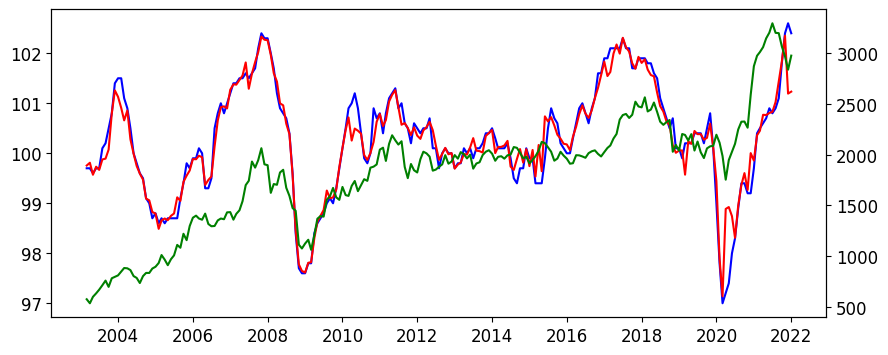

In [54]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['font.size'] = 12


fig, ax1 = plt.subplots()
ax1.plot(pp.index, pp.real, color='blue')
ax1.plot(pp.index, pp.pred, color='red')


ax2 = ax1.twinx()
ax2.plot(pp.index, pp.주가지수, color='green')

plt.show()

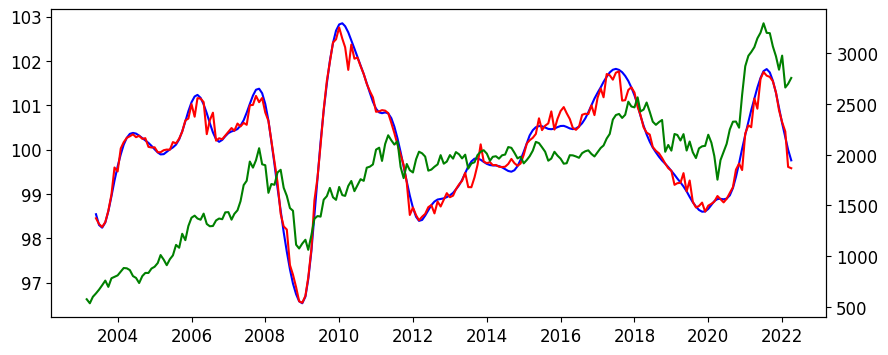

In [139]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['font.size'] = 12


fig, ax1 = plt.subplots()
ax1.plot(pp.shift(3).index, pp.real.shift(3), color='blue')
ax1.plot(pp.shift(3).index, pp.pred.shift(3), color='red')


ax2 = ax1.twinx()
ax2.plot(pp.index, pp.주가지수, color='green')

plt.show()

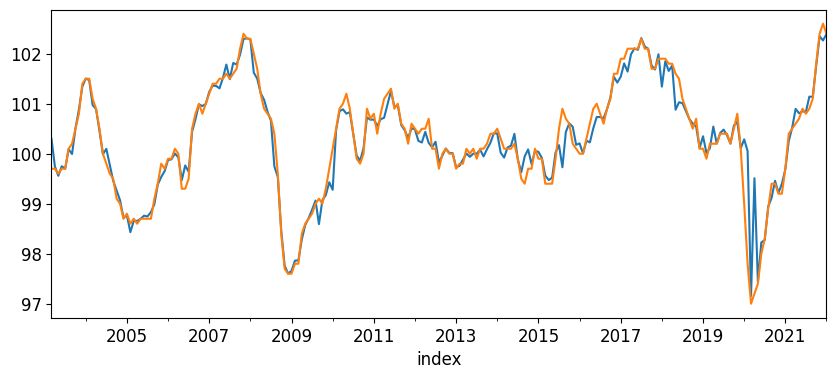

In [52]:
pp.pred.plot()
pp.real.plot()

In [50]:
from catboost import CatBoostRegressor, Pool
y_target = two_df['경기동행지수']
X_data = two_df.drop(['경기동행지수'],axis=1)
#데이터셋 나누기(train, test)
X_train,X_test,y_train,y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=12)
#모델 사용
model = CatBoostRegressor(n_estimators=1000,learning_rate=0.03, depth =5,l2_leaf_reg=3,subsample=1.0, random_state=1234)
model.fit(X_train,y_train) # pool 변수를 그대로 fit
y_preds = model.predict(X_test)

0:	learn: 1.0842843	total: 1ms	remaining: 1s
1:	learn: 1.0757579	total: 1.93ms	remaining: 961ms
2:	learn: 1.0670743	total: 4.92ms	remaining: 1.64s
3:	learn: 1.0557258	total: 5.86ms	remaining: 1.46s
4:	learn: 1.0444541	total: 6.7ms	remaining: 1.33s
5:	learn: 1.0333683	total: 7.55ms	remaining: 1.25s
6:	learn: 1.0252532	total: 8.38ms	remaining: 1.19s
7:	learn: 1.0176848	total: 9.18ms	remaining: 1.14s
8:	learn: 1.0096069	total: 9.97ms	remaining: 1.1s
9:	learn: 0.9990626	total: 11ms	remaining: 1.09s
10:	learn: 0.9900250	total: 12.4ms	remaining: 1.12s
11:	learn: 0.9787945	total: 13.9ms	remaining: 1.14s
12:	learn: 0.9691142	total: 14.7ms	remaining: 1.12s
13:	learn: 0.9618168	total: 15.6ms	remaining: 1.09s
14:	learn: 0.9551155	total: 16.4ms	remaining: 1.08s
15:	learn: 0.9467813	total: 17.2ms	remaining: 1.06s
16:	learn: 0.9400230	total: 18ms	remaining: 1.04s
17:	learn: 0.9323360	total: 18.8ms	remaining: 1.03s
18:	learn: 0.9251631	total: 19.7ms	remaining: 1.02s
19:	learn: 0.9186461	total: 21.1ms

In [51]:
mse= mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse,rmse))
print('R스퀘어 (결정계수) : {0:.3f}'.format(r2_score(y_test,y_preds)))

MSE : 0.252, RMSE : 0.502
R스퀘어 (결정계수) : 0.797


In [57]:
X_test['cli예측']=y_preds
X_test['cli실제']=y_test

In [59]:
X_test.reset_index()
X_test=X_test.sort_values(by=['index'], ascending=True)
X_test

,교역조건지수,주가지수,제조업 재고지수,제조업 출하지수,제조업 생산지수,제조업 업황전망,장단기 금리차,cli예측,cli실제
index,,,,,,,,,
2003-07-01,152.93,669.93,37.6,43.6,39.0,81.0,0.390,98.651221,98.60952
2004-01-01,149.71,810.71,36.4,48.0,43.6,90.0,0.560,100.130849,100.26760
2004-02-01,149.67,848.50,36.6,48.4,44.6,90.0,0.540,100.157596,100.35500
2004-10-01,144.86,835.09,41.4,51.5,46.5,82.0,0.550,100.062799,100.00660
2004-11-01,146.70,834.84,41.6,51.3,46.7,84.0,0.510,100.107322,99.93584
...,...,...,...,...,...,...,...,...,...
2020-11-01,97.82,2267.15,109.1,117.4,122.0,68.0,0.597,100.538268,100.62340
2020-12-01,98.19,2591.34,108.2,117.0,123.6,76.0,0.645,100.776455,100.88930
2021-06-01,95.45,3203.92,107.6,119.8,132.1,98.0,0.997,101.459850,101.73990


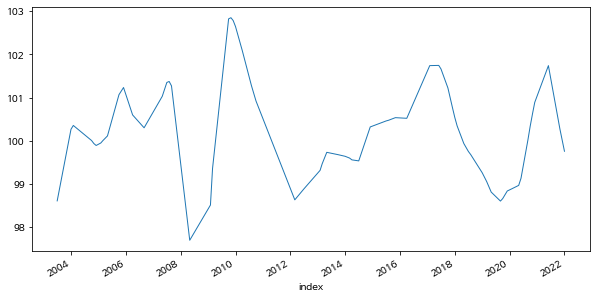

In [61]:
X_test.cli실제.plot()

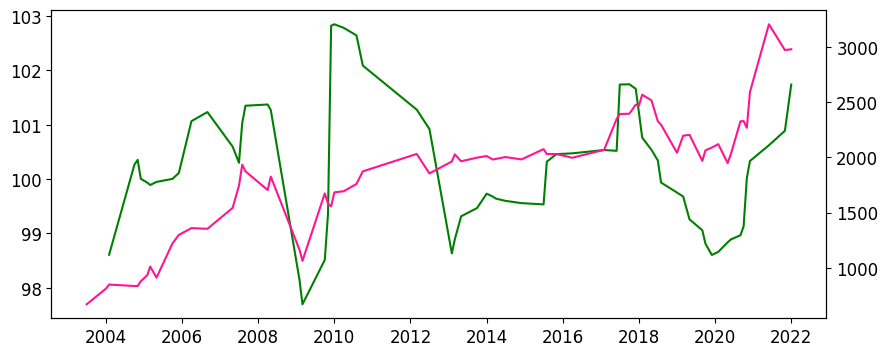

In [68]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['font.size'] = 12


fig, ax1 = plt.subplots()
ax1.plot(X_test.index, X_test.cli실제.shift(2), color='green')

ax2 = ax1.twinx()
ax2.plot(X_test.index, X_test.주가지수, color='deeppink')

plt.show()

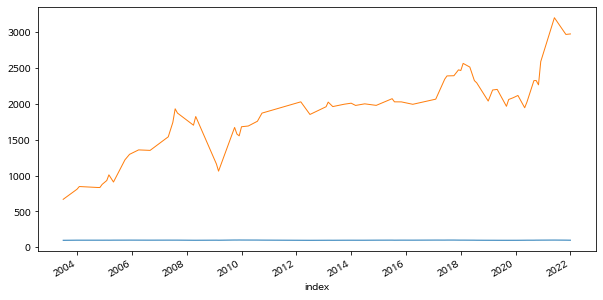

In [62]:
X_test.cli예측.plot()
X_test.주가지수.plot()

In [52]:
origin=y_test
pred=y_preds

MAE =  mean_absolute_error(origin, pred)
print("MAE : ",MAE)
MSE = mean_squared_error(origin, pred)
print("MSE : ",MSE)
RMSE = np.sqrt(MSE)
print("RMSE : ",RMSE)
MSLE = mean_squared_log_error(origin, pred)
print("MSLE : ",MSLE)
RMSLE = np.sqrt(mean_squared_log_error(origin, pred))
print("RMSLE : ",RMSLE)
R2 = r2_score(origin, pred)
print("R2 : ",R2)

MAE :  0.31953939420289534
MSE :  0.2230108436251351
RMSE :  0.47224023931166126
MSLE :  2.185677442238093e-05
RMSLE :  0.004675122931258699
R2 :  0.8301253837780999


In [79]:
origin=y_test
pred=y_preds

MAE =  mean_absolute_error(origin, pred)
print("MAE : ",MAE)
MSE = mean_squared_error(origin, pred)
print("MSE : ",MSE)
RMSE = np.sqrt(MSE)
print("RMSE : ",RMSE)
MSLE = mean_squared_log_error(origin, pred)
print("MSLE : ",MSLE)
RMSLE = np.sqrt(mean_squared_log_error(origin, pred))
print("RMSLE : ",RMSLE)
R2 = r2_score(origin, pred)
print("R2 : ",R2)

MAE :  0.29942731441424375
MSE :  0.16733016163373493
RMSE :  0.4090600953817604
MSLE :  1.6321022201050692e-05
RMSLE :  0.004039928489596158
R2 :  0.8725391710653324


In [81]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import load_iris

In [82]:
from catboost import CatBoostRegressor, Pool
y_target = a_df['CLI.KOR']
X_data = a_df.drop('CLI.KOR',axis=1)
#데이터셋 나누기(train, test)
X_train,X_test,y_train,y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=123)
#모델 사용
model = CatBoostRegressor(n_estimators=1000,learning_rate=0.03, depth =5,l2_leaf_reg=3,subsample=1.0, random_state=1234)
model.fit(X_train,y_train) # pool 변수를 그대로 fit
y_preds = model.predict(X_test)

0:	learn: 1.1938910	total: 1.51ms	remaining: 1.51s
1:	learn: 1.1797744	total: 5.35ms	remaining: 2.67s
2:	learn: 1.1644714	total: 7.09ms	remaining: 2.36s
3:	learn: 1.1509163	total: 8.14ms	remaining: 2.03s
4:	learn: 1.1374112	total: 9.11ms	remaining: 1.81s
5:	learn: 1.1235851	total: 10ms	remaining: 1.66s
6:	learn: 1.1089788	total: 11ms	remaining: 1.56s
7:	learn: 1.0930513	total: 11.9ms	remaining: 1.48s
8:	learn: 1.0789242	total: 12.8ms	remaining: 1.41s
9:	learn: 1.0688361	total: 13.7ms	remaining: 1.36s
10:	learn: 1.0559874	total: 14.7ms	remaining: 1.32s
11:	learn: 1.0463446	total: 15.6ms	remaining: 1.28s
12:	learn: 1.0348854	total: 16.5ms	remaining: 1.25s
13:	learn: 1.0216568	total: 17.3ms	remaining: 1.22s
14:	learn: 1.0101649	total: 18.2ms	remaining: 1.19s
15:	learn: 0.9973842	total: 19ms	remaining: 1.17s
16:	learn: 0.9859678	total: 19.9ms	remaining: 1.15s
17:	learn: 0.9749952	total: 21.1ms	remaining: 1.15s
18:	learn: 0.9627468	total: 22ms	remaining: 1.14s
19:	learn: 0.9511418	total: 22

In [83]:
data=a_df.drop('CLI.KOR',axis=1)
label=a_df['CLI.KOR']
skf = StratifiedKFold(n_splits=3)

print(cross_val_score(model, data, label, cv=skf))

ValueError: ignored